In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import layers
from keras.models import Model
import cv2 as cv
import string
import csv
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
CREAT_MODEL = True

In [3]:
class CapthaRec(object):

    def __init__(self):
        self.symbols = string.ascii_uppercase

    def create_model(self, img_shape):
        img = layers.Input(shape=img_shape)  # Get image as an input and process it through some Convs
        conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
        bn1 = layers.BatchNormalization()(conv1)
        mp1 = layers.MaxPooling2D(padding='same')(bn1)
        conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
        bn2 = layers.BatchNormalization()(conv2)
        mp2 = layers.MaxPooling2D(padding='same')(bn2)
        conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
        bn3 = layers.BatchNormalization()(conv3)
        mp3 = layers.MaxPooling2D(padding='same')(bn3)

        flat = layers.Flatten()(mp3)
        outs = list()
        for _ in range(6):
            dens1 = layers.Dense(len(self.symbols)*2, activation='relu')(flat)
            drop = layers.Dropout(rate=0.5)(dens1)
            res = layers.Dense(len(self.symbols), activation='sigmoid')(drop)
            outs.append(res)
        model = Model(inputs=img, outputs=outs)
        model.compile(loss='categorical_crossentropy', optimizer='adam',
                      metrics=["accuracy"])
        return model

    def gen_csv_data(self, file_path):
        with open(file_path, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                yield row

    def preprocess_data(self, data_dir, folder="train"):
        img_dir = os.path.join(data_dir, folder)
        n_samples = len(os.listdir(img_dir))
        csv_data = self.gen_csv_data(os.path.join(data_dir, 'trainLabels.csv'))
        X = np.zeros((n_samples, 70, 200, 1))  # n*70*200
        Y = np.zeros((6, n_samples, len(self.symbols)))  # 6*n*32
        for i, row in enumerate(csv_data):
            img_path = os.path.join(img_dir, row[0])
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            pic_target = row[1]
            if img.shape != (70, 200):
                img = cv.resize(img, (200, 70))
            if len(pic_target) != 6:
                print("Lengh Error: ", img_path)
            else:
                # Scale and reshape image
                img = img / 255.0
                img = np.reshape(img, (70, 200, 1))
                targs = np.zeros((len(pic_target), len(self.symbols)))
                for j, l in enumerate(pic_target):
                    ind = self.symbols.find(l)
                    targs[j, ind] = 1
                X[i] = img
                Y[:, i] = targs
        return X, Y

    def predict(self, model, filepath):
        img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
        if img is not None:
            if img.shape != (70, 200):
                img = cv.resize(img, (200, 70))
            img = img / 255.0
        else:
            print(filepath, "Not detected");
            return
        img = img[np.newaxis, :, :, np.newaxis]
        res = model.predict(img)
        res = np.array(res)
        ans = np.reshape(res, (6, len(string.ascii_uppercase)))
        l_ind = list()
        probs = list()
        capt = list()
        for a in ans:
            l_ind.append(np.argmax(a))
            probs.append(np.max(a))
        for l in l_ind:
            capt.append(self.symbols[l])
        return "".join(capt), sum(probs) / 6

In [4]:
def main():
    cr = CapthaRec()
    X, Y = cr.preprocess_data("/kaggle/input")

    if CREAT_MODEL:
        model = cr.create_model((70, 200, 1))
        model.summary()
        model.fit(
            X, [Y[0], Y[1], Y[2], Y[3], Y[4], Y[5]],
            batch_size=16, epochs=100, shuffle=True, verbose=0)
        model.save('cpr.h5')
    model = load_model('cpr.h5')
    test_path = "/kaggle/input/test/665"
    img = cv.imread(test_path, cv.IMREAD_GRAYSCALE)
    pv = cr.predict(model, test_path)
    print("Predicted Captcha =", pv)
    plt.imshow(img)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70, 200, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 70, 200, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 70, 200, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 35, 100, 16)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

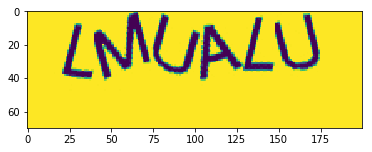

In [5]:
main()

In [6]:
def check_captha(dir_path='/kaggle/input/test', number=25):
    model = load_model('cpr.h5')
    cr = CapthaRec()
    plt.figure(figsize=(10,10))
    for dirname, _, filenames in os.walk(dir_path):
        for n,filename in enumerate(filenames,1):
            if n <= number:
                img_path = (os.path.join(dirname, filename))
                pima = cr.predict(model, img_path)
                img = cv.imread(img_path)
                plt.subplot(5,5,n)
                plt.imshow(img)
                plt.xlabel(pima[0])
                plt.xticks([])
                plt.yticks([])
            else:
                break


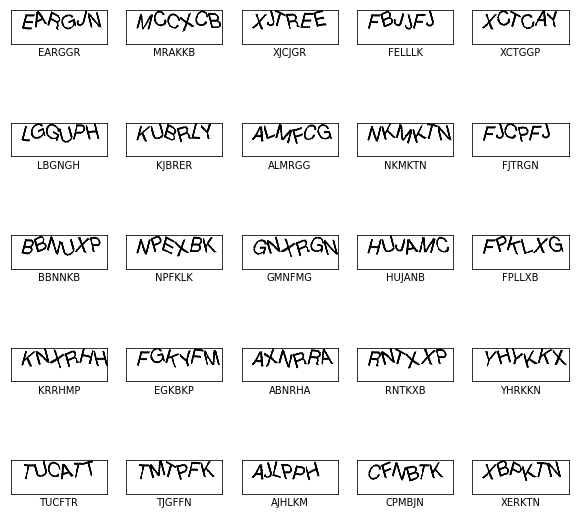

In [7]:
check_captha()